# Module 10 Challenge: SurfsUp
---
# Part 1: Analyze and Explore the Climate Data

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite",echo=False, future=True)

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measure = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Exploratory Precipitation Analysis

In [9]:
# Create the inspector and connect it to the engine - to confirm the tables and get column info
inspector = inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Column information for table:
col_measure = inspect(engine).get_columns('measurement')

#This for loop onl provides the column name and the type
for column in col_measure:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Column information for table:
col_station = inspect(engine).get_columns('station')

#This for loop onl provides the column name and the type
for column in col_station:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Find the most recent date in the data set.
# Since it is the 'measurement' Table that have date info, the query will be executed on that table

recent_date = session.query(Measure.date).order_by(Measure.date.desc()).first()

print(f" The most recent date is {recent_date.date} in the table 'measurement'.")

 The most recent date is 2017-08-23 in the table 'measurement'.


**Instructions**
- Design a query to retrieve the last 12 months of precipitation data and plot the results. 
- Since it is the 'measurement' Table that have those info, the query will be executed on that table

In [13]:
# Starting from the most recent data point in the database (above),
# Calculate the date one year from the last date in data set.

# Query the data for a year's worth of data 1mth before `2017-08-23` using the datetime library
start_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

print("Query Start Date: ", start_date)

Query Start Date:  2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores
last_12_mths = session.query(Measure.date, Measure.prcp).\
    filter(Measure.date <= recent_date.date).\
    filter(Measure.date >= start_date).\
    order_by(Measure.date).all()

print(f"The amount of the data retrieved for the previous 12 months of precipitation data is: {len(last_12_mths)}.")

The amount of the data retrieved for the previous 12 months of precipitation data is: 2230.


In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
chart_12_mths = pd.DataFrame(last_12_mths, columns=['Date','Precipitation'])

#Setting the index to the date column
chart_12_mths.set_index('Date', inplace = True)

# Sort the dataframe by date (dropping NA values as well)
chart_12_mths = chart_12_mths.dropna(how='any').sort_values("Date")

chart_12_mths.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


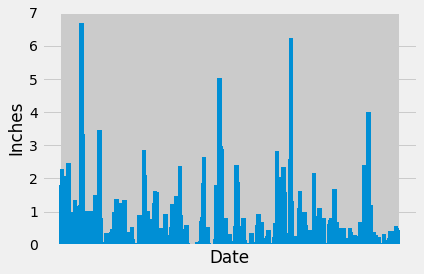

In [16]:
xvalue = chart_12_mths.index
yvalue = chart_12_mths["Precipitation"]


plt.bar( xvalue, yvalue, width =5)
#plt.figure(figsize=(20,10))
plt.ylabel("Inches")
plt.xlabel("Date")
plt.tick_params(labelbottom = False)
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
chart_12_mths.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset

station_count =session.query(Measure.station).distinct().count()

print(f"There are {station_count} stations in the measurement table dataset.")


There are 9 stations in the measurement table dataset.


In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)

#Create a list of distinct stations in the table
station_list = session.query(Measure.station).distinct().all()

#Creating a filter based on the list of distinct stations in station_list
count_station=[] # List to store the station name and num of occurrence

for loc in station_list:
    station_info = session.query(Measure.station, func.count(Measure.station)).\
        filter(Measure.station==loc.station).first()
    count_station.append(station_info)

    
count_station

[('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00514830', 2202),
 ('USC00517948', 1372),
 ('USC00518838', 511),
 ('USC00519523', 2669),
 ('USC00519281', 2772),
 ('USC00511918', 1979),
 ('USC00516128', 2612)]

In [20]:
# List the stations and the counts in descending order.
station_num = pd.DataFrame(count_station, columns =["Station","Count"]).sort_values("Count", ascending =False)
station_num


,Station,Count
6,USC00519281,2772
0,USC00519397,2724
1,USC00513117,2709
5,USC00519523,2669
8,USC00516128,2612
2,USC00514830,2202
7,USC00511918,1979
3,USC00517948,1372
4,USC00518838,511


In [21]:

max_count = station_num["Count"].max()

#Getting the Station name info for the max occurrence
max_station = station_num.loc[(station_num["Count"] == max_count), :]
max_station

,Station,Count
6,USC00519281,2772


In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel =[Measure.station,
      func.min(Measure.tobs),
      func.max(Measure.tobs),
      func.avg(Measure.tobs)
     ]

freq_station = session.query(*sel).\
    filter(Measure.station == "USC00519281").all()

print(f"Station {freq_station[0][0]} occurred {max_count} times in the table. Below is an overview of the station")
print(f"Minimum Temperature {freq_station[0][1]}")
print(f"Maximum Temperature {freq_station[0][2]}")
print(f"Average Temperature {freq_station[0][3]}")

Station USC00519281 occurred 2772 times in the table. Below is an overview of the station
Minimum Temperature 54.0
Maximum Temperature 85.0
Average Temperature 71.66378066378067


In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_last_12_mths = session.query(Measure.date, Measure.station, Measure.tobs).\
    filter(Measure.station == "USC00519281").\
    filter(Measure.date <= recent_date.date).\
    filter(Measure.date >= start_date).\
    order_by(Measure.date).all()


In [24]:
# Converting temp_last_12_mths into a dataframe to plot the histogram
station_hist = pd.DataFrame(temp_last_12_mths, columns =["Date","Station","tobs"])
station_hist.head(3)


,Date,Station,tobs
0,2016-08-23,USC00519281,77.0
1,2016-08-24,USC00519281,77.0
2,2016-08-25,USC00519281,80.0


Text(0.5, 0, 'Temperature')

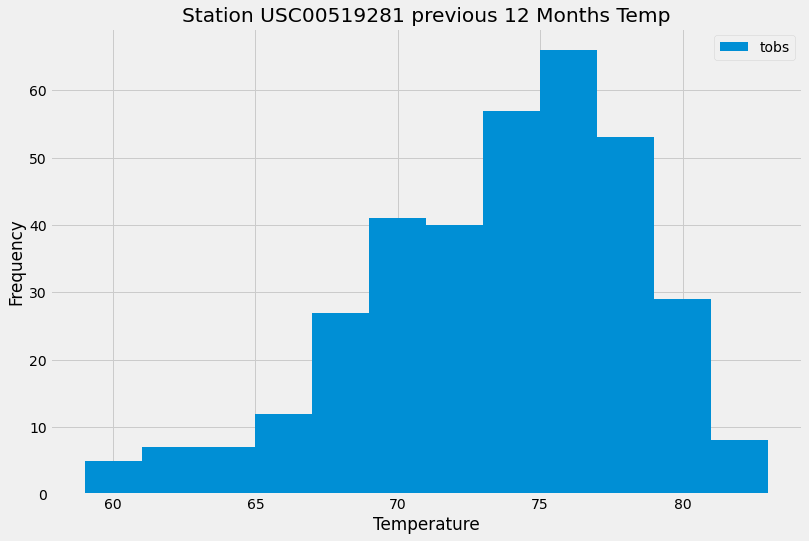

In [25]:
station_hist.plot.hist(bins=12, figsize=(12,8), title="Station USC00519281 previous 12 Months Temp")
plt.xlabel("Temperature")


## Close session

In [26]:
# Close Session
session.close()